In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('RedditSubmissionsClean.csv').drop('Unnamed: 0', axis = 1)
df.head()

,upvotes,date,title,username,subreddit,text,post_id
0,43,2023-07-01,Will Israel still be habitable in the decades ...,u/TransThrowaway4096,r/Israel,"One of my dreams to make Aliyah, but as as the...",14ngcep
1,28,2023-07-01,What am I? I feel like an imposter.,u/Iamthe_slime,r/Jewish,Idrk what I expect from this but I feel like I...,14nwxg7
2,3,2023-07-01,Leatherwork Store,u/aritex90,r/Israel,Is there any hobby shop or art store that I ca...,14nxnnm
3,8,2023-07-01,Need help with second hand/used furniture home...,u/Turbulent-Attempt-71,r/Israel,"Hi guys,\n\nSo I'm finally leaving my relative...",14nxo7m
4,1,2023-07-01,Vengeful God’s wisdom,u/samlerman,r/Judaism,God set fire to every part of my life on the m...,14nxugl


In [3]:
df.subreddit.value_counts()

subreddit
r/Judaism            7307
r/IsraelPalestine    6667
r/Israel             5960
r/Jewish             4666
r/Palestine          1412
Name: count, dtype: int64

In [4]:
df_predicted = pd.read_csv('IsraelPalestinePredicted.csv').drop(['Unnamed: 0.1','Unnamed: 0'], axis = 1)
df_predicted.head()

,upvotes,date,title,username,subreddit,text,post_id,predicted_label
0,16,2023-07-01,How likely is a peace treaty between Israel an...,u/ANobodyBoy,r/IsraelPalestine,Either for a two-state solution or a one-state...,14o273q,0
1,5,2023-07-01,The lies of the anti-zionist movement,u/One-Trash3743,r/IsraelPalestine,Antizionists always claim that they're not aga...,14niaul,0
2,1,2023-07-01,THE KINGDOM OF JERUSALEM IS FOREVER,u/TheBasedFeudalist163,r/IsraelPalestine,Reject the false dichotomy both states are the...,14nmufa,0
3,1,2023-07-01,Anyone looking to discuss the conflict,u/Salty_Werewolf6532,r/IsraelPalestine,Looking for a pro Palestinian to discuss the c...,14nt4nu,1
4,2,2023-07-02,Does anyone think a one state solution is even...,u/SoleySaul,r/IsraelPalestine,I have never been a proponent of a one state s...,14opxhk,0


In [5]:
df_pred_is = df_predicted[df_predicted.predicted_label == 0]
df_pred_pal = df_predicted[df_predicted.predicted_label == 1]

In [6]:
df_sub_is = df[df.subreddit == 'r/Israel']
df_sub_pal = df[df.subreddit == 'r/Palestine']

Merge all pro-Israel/pro-Palestine content together

In [7]:
df_israel = pd.concat([df_pred_is, df_sub_is], ignore_index=True)
df_palestine = pd.concat([df_pred_pal, df_sub_pal], ignore_index=True)
print(f'Shape of Israel Dataset: {df_israel.shape}, Shape of Palestine Dataset: {df_palestine.shape}')

Shape of Israel Dataset: (10895, 8), Shape of Palestine Dataset: (3144, 8)


### Add title to the text to be analyzed as it might contain important information

In [8]:
df_israel['title_text'] = df_israel.title + ' ' + df_israel.text
df_palestine['title_text'] = df_palestine.title + ' ' + df_palestine.text

### Topic Modeling on Israel/Palestine dataset

First step of preprocessing: lemmatize and keep only 'content' words

In [9]:
import spacy
nlp = spacy.load('en_core_web_sm')
def clean(text):
    return ' '.join([token.lemma_ 
            for token in nlp(text) 
            if token.pos_ in {'NOUN', 'ADJ', 'VERB', 'PROPN'}]) 

In [10]:
df_israel.loc[: ,'text_cleaned'] = df_israel.title_text.apply(clean)

In [11]:
df_palestine.loc[: ,'text_cleaned'] = df_palestine.title_text.apply(clean)

Second step of preprocessing: demojize, remove https, remove mentions (@), remove all non aphabet letters, and all words with less tha 3 characters

In [ ]:
%pip install emoji

In [12]:
import emoji
import re

def clean2(text):
    text = text.lower()
    text = emoji.demojize(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = ' '.join([word for word in text.split() if len(word) > 2])
    return text

In [13]:
df_israel.loc[:,'text_cleaned_2'] = df_israel.text_cleaned.apply(clean2)

In [14]:
df_palestine.loc[:,'text_cleaned_2'] = df_palestine.text_cleaned.apply(clean2)

In [15]:
df_israel.text_cleaned_2

0        likely peace treaty israel palestine next few ...
1        lie anti zionist movement antizionist claim je...
2        kingdom jerusalem reject false dichotomy state...
3        think state solution viable proponent state so...
4        difficult find trusted statistics think lot pe...
                               ...                        
10890    compelling succinct education friend try come ...
10891    troll encampment buddy live university campus ...
10892    letter president bush write prime minister ari...
10893    gen american critique western pro israel senti...
10894    death sentence terrorist know israel have deat...
Name: text_cleaned_2, Length: 10895, dtype: object

Remove observations with no text

In [16]:
df_israel = df_israel[df_israel['text_cleaned_2'].notnull() & (df_israel['text_cleaned_2'] != '')]
df_israel['text_cleaned_2'] = df_israel['text_cleaned_2'].apply(str)

len(df_israel)

10762

In [17]:
df_palestine = df_palestine[df_palestine['text_cleaned_2'].notnull() & (df_palestine['text_cleaned_2'] != '')]
df_palestine['text_cleaned_2'] = df_palestine['text_cleaned_2'].apply(str)

len(df_palestine)

3132

## Dynamic Topic Modeling (BERTopic)

In [18]:
%pip install bertopic
from bertopic import BERTopic

c:\Users\fedeu\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Israel

In [19]:
df_israel['date'] = pd.to_datetime(df_israel['date'])
timestamps = df_israel.date.to_list()
texts = df_israel.text_cleaned_2.to_list()

In [ ]:
%pip install umap

In [20]:
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=42)

In [21]:
topic_model_is = BERTopic(verbose=True, umap_model=umap_model)
topics_is, probs_is = topic_model_is.fit_transform(texts)

2024-05-22 12:12:59,520 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 337/337 [05:54<00:00,  1.05s/it]
2024-05-22 12:18:58,226 - BERTopic - Embedding - Completed ✓
2024-05-22 12:18:58,227 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-22 12:19:30,651 - BERTopic - Dimensionality - Completed ✓
2024-05-22 12:19:30,654 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-22 12:19:31,166 - BERTopic - Cluster - Completed ✓
2024-05-22 12:19:31,176 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-22 12:19:31,992 - BERTopic - Representation - Completed ✓


In [22]:
topics_over_time_is = topic_model_is.topics_over_time(texts, timestamps, nr_bins=45)

45it [00:05,  8.40it/s]


In [23]:
topic_model_is.get_topic_info().loc[0:10, :]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5932,-1_israel_people_have_hamas,"[israel, people, have, hamas, palestinians, wa...",[peace plan israel palestine shocked event hap...
1,0,229,0_anti_zionism_zionist_antisemitic,"[anti, zionism, zionist, antisemitic, antisemi...",[zionist mean anti zionist mean wonder time id...
2,1,223,1_hostage_release_prisoner_hamas,"[hostage, release, prisoner, hamas, exchange, ...",[israel release many terrorist israeli hostage...
3,2,181,2_job_university_moshe_degree,"[job, university, moshe, degree, work, ari, st...",[job opportunity computer scientist europe yea...
4,3,125,3_iran_iranian_nuclear_iranians,"[iran, iranian, nuclear, iranians, attack, reg...",[interesting article iran military capability ...
5,4,119,4_hamas_gaza_israel_destroy,"[hamas, gaza, israel, destroy, attack, war, en...",[hamas destroy israel more hamas destroy end c...
6,5,117,5_sub_ban_subreddit_post,"[sub, ban, subreddit, post, comment, moderator...",[help regard reddit sub wish love one side con...
7,6,116,6_solution_state_bank_west,"[solution, state, bank, west, palestinians, bo...",[question palestinians most palestinians belie...
8,7,88,7_video_evidence_telegram_footage,"[video, evidence, telegram, footage, propagand...",[trust bro sutte mean disrespect give link dan...
9,8,85,8_number_civilian_death_casualty,"[number, civilian, death, casualty, kill, hama...",[question israel supporter senior hamas comman...


In [24]:
topic_model_is.visualize_topics_over_time(topics_over_time_is, topics=[0, 1, 2, 3])

In [25]:
topics_over_time_is['Relative Frequency'] = topics_over_time_is.groupby('Timestamp')['Frequency'].transform(lambda x: x / x.sum())

fig = topic_model_is.visualize_topics_over_time(topics_over_time_is, topics=[0, 1, 2, 3], normalize_frequency=True)
fig.show()

In [98]:
df = topics_over_time_is[(topics_over_time_is.Topic == 0) | (topics_over_time_is.Topic == 1) | (topics_over_time_is.Topic == 2) | (topics_over_time_is.Topic == 3)]

The following is done to show persistency of results (using relative frequency)

<Axes: xlabel='Timestamp', ylabel='Relative Frequency'>

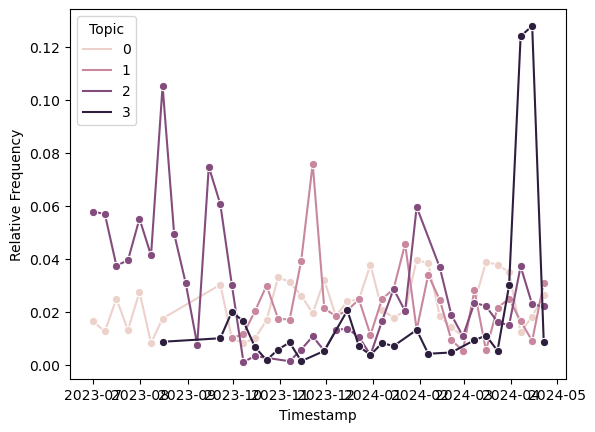

In [99]:
import seaborn as sns
sns.lineplot(data=df, x='Timestamp', y='Relative Frequency', hue='Topic', marker='o')

### Palestine

In [29]:
df_palestine['date'] = pd.to_datetime(df_palestine['date'])
timestamps = df_palestine.date.to_list()
texts = df_palestine.text_cleaned_2.to_list()

In [30]:
topic_model_pal = BERTopic(verbose=True, umap_model=umap_model)
topics_pal, probs_pal = topic_model_pal.fit_transform(texts)

2024-05-22 12:58:08,120 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 98/98 [01:43<00:00,  1.05s/it]
2024-05-22 12:59:54,167 - BERTopic - Embedding - Completed ✓
2024-05-22 12:59:54,169 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-22 13:00:15,322 - BERTopic - Dimensionality - Completed ✓
2024-05-22 13:00:15,324 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-22 13:00:15,434 - BERTopic - Cluster - Completed ✓
2024-05-22 13:00:15,436 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-22 13:00:15,768 - BERTopic - Representation - Completed ✓


In [31]:
topic_model_pal.get_topic_info().loc[0:15, :]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1736,-1_israel_people_have_palestinians,"[israel, people, have, palestinians, palestine...",[harsh rule zions breed extremism occupied pal...
1,0,97,0_donate_help_aid_volunteer,"[donate, help, aid, volunteer, charity, organi...",[help help friend want donate help gazans know...
2,1,82,1_protest_saturday_rally_february,"[protest, saturday, rally, february, people, k...",[more people talk march return gazans protest ...
3,2,73,2_video_baby_find_footage,"[video, baby, find, footage, behead, see, imag...",[need footage dead israeli baby friend muslim ...
4,3,63,3_solution_state_land_israel,"[solution, state, land, israel, palestine, pal...",[problem state solution research opinion peopl...
5,4,61,4_post_comment_ban_reddit,"[post, comment, ban, reddit, subreddit, pro, s...",[unable see comment post sub problem end reddi...
6,5,57,5_hamas_israel_attack_gaza,"[hamas, israel, attack, gaza, war, eye, try, g...",[offer solution entire gaza lebanon situation ...
7,6,55,6_starbucks_boycott_certain_company,"[starbucks, boycott, certain, company, coca, c...",[unpopular opinion starbucks botcott ridiculou...
8,7,53,7_land_jews_british_state,"[land, jews, british, state, arab, jewish, pal...",[history mystery long promise read educate lot...
9,8,51,8_genocide_ethnic_group_area,"[genocide, ethnic, group, area, cleansing, cou...",[let have discussion israel commit genocide st...


In [178]:
topics_over_time_pal = topic_model_pal.topics_over_time(texts, timestamps, nr_bins=25)

25it [00:01, 15.67it/s]


In [78]:
topic_model_pal.visualize_topics_over_time(topics_over_time_pal, topics=[0, 3, 5, 21])

In [75]:
topics_over_time_pal['Relative Frequency'] = topics_over_time_pal.groupby('Timestamp')['Frequency'].transform(lambda x: x / x.sum())

fig = topic_model_pal.visualize_topics_over_time(topics_over_time_pal, topics=[0, 3, 5, 21], normalize_frequency=True)
fig.show()

## Plots of Topic Embedding

In [26]:
import numpy as np

In [41]:
topic_embeddings_is = topic_model_is.topic_embeddings_
topic_size_is = topic_model_is.topic_sizes_.most_common(200)
topic_size_is = [topic_size_is[x][1] for x in range(len(topic_size_is))]

In [32]:
topic_embeddings_pal = topic_model_pal.topic_embeddings_
topic_size_pal = topic_model_pal.topic_sizes_.most_common(200)
topic_size_pal = [topic_size_pal[x][1] for x in range(len(topic_size_pal))]

In [33]:
import matplotlib.pyplot as plt
def set_plot_style(ax, title=None, xlabel=None, ylabel=None, xscale='linear', yscale='linear', xlims=None, ylims=None, xticks=None, yticks=None, xticklabels=None, yticklabels=None, legend=True, legend_args={}, xticklabels_args={}, yticklabels_args={}):
    ax.set_title(title, fontweight='semibold')
    ax.set_xlabel(xlabel, fontweight='semibold', color='#454545')
    ax.set_ylabel(ylabel, fontweight='semibold', color='#454545')
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if legend: ax.legend(frameon = False,**legend_args)
    if not xlims is None: ax.set_xlim(xlims)
    if not ylims is None: ax.set_ylim(ylims)
    if not xticks is None: ax.set_xticks(xticks)
    if not yticks is None: ax.set_yticks(yticks)
    if not xticklabels is None: ax.set_xticklabels(xticklabels, **xticklabels_args)
    if not yticklabels is None: ax.set_xticklabels(yticklabels, **yticklabels_args)

    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)
    
plt.rcParams.update({'font.size': 10, 'font.style': 'normal', 'font.family':'serif'})

### Using t-SNE

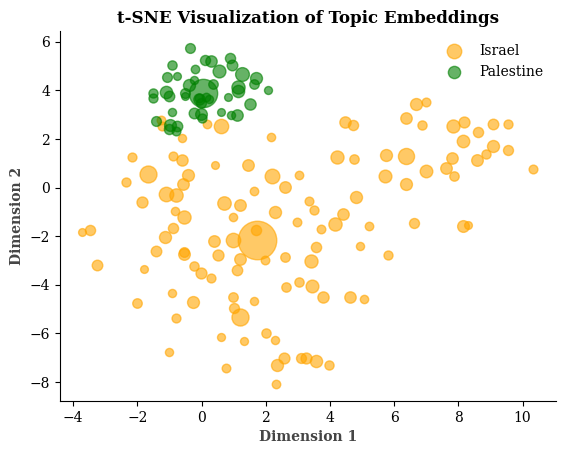

In [49]:

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


# Compute pairwise similarities between topic embeddings
similarities_is = cosine_similarity(topic_embeddings_is)
similarities_pal = cosine_similarity(topic_embeddings_pal)


# Apply t-SNE for dimensionality reduction 
tsne = TSNE(n_components=2, perplexity = 30, random_state=42)
embeddings_2d_is = tsne.fit_transform(topic_embeddings_is)
embeddings_2d_pal = tsne.fit_transform(topic_embeddings_pal)
labels_is = np.arange(0, len(topic_embeddings_is))
labels_pal = np.arange(0, len(topic_embeddings_pal))

# Plot
fig, ax = plt.subplots()
for i, label in enumerate(labels_is):
    x1, y1 = embeddings_2d_is[i, 0], embeddings_2d_is[i, 1]
    ax.scatter(x1, y1, c='orange', marker='o', s = 10* np.sqrt(topic_size_is[i]), alpha = 0.6, label = 'Israel' if i == 5 else '')

for i, label in enumerate(labels_pal):
    x2, y2 = embeddings_2d_pal[i, 0], embeddings_2d_pal[i, 1]
    ax.scatter(x2, y2, c='green', marker='o', s = 10* np.sqrt(topic_size_pal[i]), alpha = 0.6, label = 'Palestine' if i == 5 else '')

set_plot_style(ax,title='t-SNE Visualization of Topic Embeddings' ,xlabel='Dimension 1',ylabel='Dimension 2')



### Using PCA

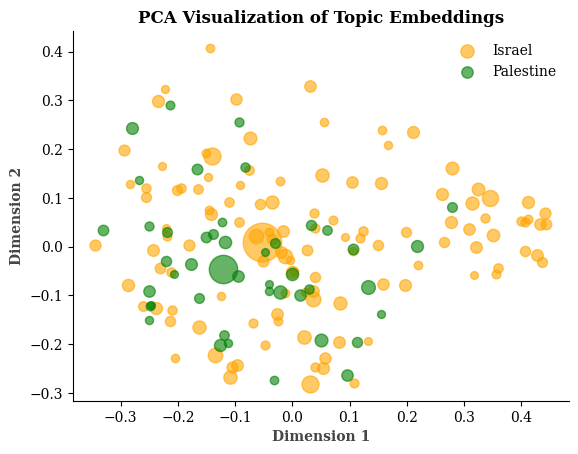

In [52]:
from sklearn.decomposition import PCA

# Compute pairwise similarities between topic embeddings
similarities = cosine_similarity(topic_embeddings_is)

# Apply t-SNE for dimensionality reduction with lower perplexity
pca = PCA(n_components=2, random_state=42)

pca.fit(np.concatenate((topic_embeddings_is, topic_embeddings_pal), axis=0))
embeddings_2d_is = pca.transform(topic_embeddings_is)
embeddings_2d_pal = pca.transform(topic_embeddings_pal)

# Create labels for topics
labels_is = np.arange(0, len(topic_embeddings_is))
labels_pal = np.arange(0, len(topic_embeddings_pal))

# Plot the 2D embeddings with labels
fig, ax = plt.subplots()
for i, label in enumerate(labels_is):
    x1, y1 = embeddings_2d_is[i, 0], embeddings_2d_is[i, 1]
    ax.scatter(x1, y1, c='orange', marker='o', s = 10* np.sqrt(topic_size_is[i]), alpha = 0.6, label = 'Israel' if i == 10 else '')

for i, label in enumerate(labels_pal):
    x2, y2 = embeddings_2d_pal[i, 0], embeddings_2d_pal[i, 1]
    ax.scatter(x2, y2, c='green', marker='o', s = 10* np.sqrt(topic_size_pal[i]), alpha = 0.6, label = 'Palestine' if i == 10 else '')

set_plot_style(ax,title='PCA Visualization of Topic Embeddings', xlabel='Dimension 1', ylabel='Dimension 2', legend=True)